# Reproduction
The following notebook aims at reproducing the __empirical results__ from the paper "[Feature learning in neural networks and kernel machines that recursively learn features](https://arxiv.org/abs/2212.13881)". The experiments aim at showing that RFMs are able to learn extremely similar features to those learned by neural networks. The reproduction focuses on 3 experiments:
1. __Key result__: RFMs and neural networks learn similar features
2. __Tabular data__: RFMs outperforms most models on tabular data
3. __Special phenomena__: Neural networks and RFMs exhibit grokking and simplicity bias

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
import time

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import numpy as np
import matplotlib.pyplot as plt

plt.ion()

from IPython.display import Markdown

import rfm
import nn
import xgb
from utils import suppress_stdout
from visualize import visualize_M_dict, visualize_curves_dict

/home/ggalletti/git/recursive_feature_machines_praktikum/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data

In [2]:
from torchvision import transforms
from torchvision.datasets import CelebA, STL10

# datasets to load
DATASETS = ["celeba", "stl10"]

SEED = 1337
torch.manual_seed(SEED)
np.random.seed(SEED)
# frame size
CELEBA_SIZE = 24
STL10_SIZE = 96 // 2

with suppress_stdout():
    dataset_path = os.path.join(os.getcwd(), "datasets")
    if not os.path.exists(dataset_path):
        os.makedirs(dataset_path)
    # create datasets
    if "celeba" in DATASETS:
        celeba_transform = transforms.Compose(
            [transforms.Resize([CELEBA_SIZE, CELEBA_SIZE]), transforms.ToTensor()]
        )
        celeba_trainset_full = CelebA(
            root=dataset_path, split="train", transform=celeba_transform, download=True
        )
        celeba_testset_full = CelebA(
            root=dataset_path, split="test", transform=celeba_transform, download=True
        )

    if "stl10" in DATASETS:
        stl10_transform = transforms.Compose(
            [transforms.Resize([STL10_SIZE, STL10_SIZE]), transforms.ToTensor()]
        )
        stl10_trainset_full = STL10(
            root=dataset_path, split="train", transform=stl10_transform, download=True
        )
        stl10_testset_full = STL10(
            root=dataset_path, split="test", transform=stl10_transform, download=True
        )

## 1. Key result: RFMs and neural networks learn similar features
The original paper shows that RFMs and neural networks learn similar features on the [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset. The following code just focuses on that, as it's the main empirical results that motivates the usefulness of RFMs in the study of neural networks.

### Training on __glasses__

#### Train size 104, val size 26

| Metric | RFM | MLP |
| --- | --- | --- |
| Params | NA | 328192 |
| Time | 0.59s | 36.38s |
| Accuracy | 61.76% | 50.00% |
| MSE | 0.25 | 0.25 |


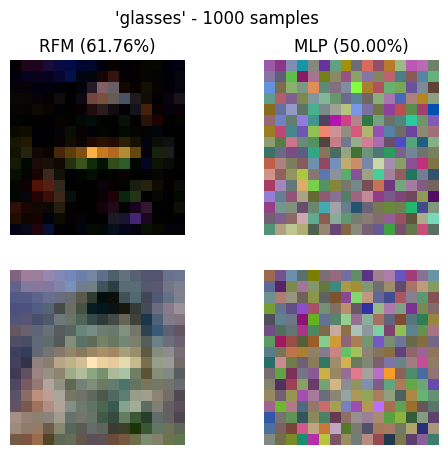

Diagonal matrix Pearson correlation: 0.25, eigenvectors Pearson correlation: 0.80

#### Train size 1078, val size 270

| Metric | RFM | MLP |
| --- | --- | --- |
| Params | NA | 328192 |
| Time | 0.99s | 46.96s |
| Accuracy | 80.36% | 71.79% |
| MSE | 0.15 | 0.20 |


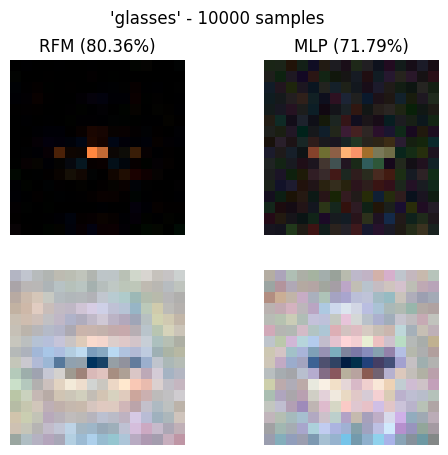

Diagonal matrix Pearson correlation: -0.22, eigenvectors Pearson correlation: 0.17

#### Train size 5200, val size 1300

| Metric | RFM | MLP |
| --- | --- | --- |
| Params | NA | 328192 |
| Time | 4.86s | 75.10s |
| Accuracy | 83.73% | 83.73% |
| MSE | 0.12 | 0.11 |


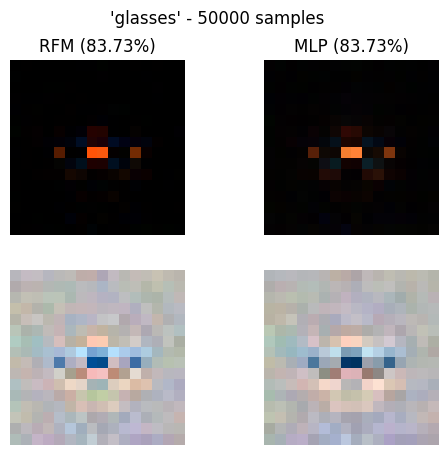

Diagonal matrix Pearson correlation: -0.08, eigenvectors Pearson correlation: -0.20

---

In [45]:
from data_utils import get_celeba_balanced_data, split

# number of celebA training samples
CELEBA_N_REGIMES = [1000, 10000, 50000]
CELEBA_TARGETS = ["glasses"]

for key in CELEBA_TARGETS:
    display(Markdown(f"### Training on __{key}__"))

    for n_train in CELEBA_N_REGIMES:
        n_test = n_train // 5

        celeba_trainset = get_celeba_balanced_data(
            celeba_trainset_full, num_samples=n_train, target=key
        )
        celeba_trainset, valset = split(celeba_trainset, p=0.8)

        display(
            Markdown(f"#### Train size {len(celeba_trainset)}, val size {len(valset)}")
        )

        trainloader = torch.utils.data.DataLoader(
            celeba_trainset, batch_size=128, shuffle=True, num_workers=2
        )

        valloader = torch.utils.data.DataLoader(
            valset, batch_size=100, shuffle=False, num_workers=1
        )

        celeba_testset = get_celeba_balanced_data(
            celeba_testset_full, num_samples=n_test, target=key
        )

        testloader = torch.utils.data.DataLoader(
            celeba_testset, batch_size=512, shuffle=False, num_workers=1
        )

        start = time.perf_counter_ns()
        M_rfm, mse_rfm, acc_rfm, _ = rfm.train(trainloader, testloader, iters=1)
        time_rfm = (time.perf_counter_ns() - start) / 1e9

        start = time.perf_counter_ns()
        mlp, mse_mlp, acc_mlp, _ = nn.train(trainloader, valloader, testloader)
        time_mlp = (time.perf_counter_ns() - start) / 1e9
        n_params = sum(p.numel() for p in mlp.parameters() if p.requires_grad)

        table = f"| Metric | RFM | MLP |\n| --- | --- | --- |\n"
        table += f"| Params | NA | {n_params} |\n"
        table += f"| Time | {time_rfm:.2f}s | {time_mlp:.2f}s |\n"
        table += f"| Accuracy | {acc_rfm:.2f}% | {acc_mlp:.2f}% |\n"
        table += f"| MSE | {mse_rfm:.2f} | {mse_mlp:.2f} |\n"

        display(Markdown(table))

        F_dict, _ = visualize_M_dict(
            {f"RFM": (acc_rfm, M_rfm), f"MLP": (acc_mlp, mlp.M)},
            title=f"'{key}' - {n_train} samples",
        )
        plt.show()

        corr_diag = np.corrcoef(
            F_dict["RFM"][1].mean(-1) / np.linalg.norm(F_dict["RFM"][1].mean(-1)),
            F_dict["MLP"][1].mean(-1) / np.linalg.norm(F_dict["MLP"][1].mean(-1)),
            rowvar=False,
        )[0, 1]
        corr_eig = np.corrcoef(
            F_dict["RFM"][2].mean(-1) / np.linalg.norm(F_dict["RFM"][2].mean(-1)),
            F_dict["MLP"][2].mean(-1) / np.linalg.norm(F_dict["MLP"][2].mean(-1)),
            rowvar=False,
        )[0, 1]
        display(
            Markdown(
                f"Diagonal matrix Pearson correlation: {corr_diag:.2f}, "
                f"eigenvectors Pearson correlation: {corr_eig:.2f}"
            )
        )

    display(Markdown("---"))

## 2. Tabular data: RFMs outperforms most models on tabular data
Reportedly RFMs get better accuracy on tabular benchmark datasets than other models, such as XGBoost and MLPs. This sections reproduces those results on a couple of benchmarks.

In [2]:
from data_utils import get_tabular_datasets

N_SAMPLES_TABULAR = 10000

TABULAR_DATASETS = [
    "electricity",
    "miniboone",
    "higgs",
    "jannis",
    "covertype",
]

table_dataset_dict = get_tabular_datasets(TABULAR_DATASETS, num_samples=N_SAMPLES_TABULAR)

In [3]:
from data_utils import split


result_dict = {}

for name, data in table_dataset_dict.items():
    table_train_data, table_evaluation_data = split(data, p=0.6)
    table_val_data, table_test_data = split(table_evaluation_data, p=0.5)

    display(
        Markdown(
            f"Training on '__{name}__'\n"
            f"Train size: {len(table_train_data)}, eval size: {len(table_val_data)}"
        )
    )

    table_trainloader = torch.utils.data.DataLoader(
        table_train_data, batch_size=1024, shuffle=True, num_workers=2
    )
    table_valloader = torch.utils.data.DataLoader(
        table_val_data, batch_size=100, shuffle=False, num_workers=1
    )
    table_testloader = torch.utils.data.DataLoader(
        table_test_data, batch_size=512, shuffle=False, num_workers=1
    )

    _, mse_rfm, acc_rfm, _ = rfm.train(
        table_trainloader, table_testloader, iters=2
    )
    _, mse_mlp, acc_mlp, _ = nn.train(
        table_trainloader, table_valloader, table_testloader, lr=1e-2, num_layers=6
    )
    mse_xgb, acc_xgb = xgb.train(table_train_data, table_test_data)
    
    result_dict[name] = {
        "RFM": (mse_rfm, acc_rfm),
        "MLP": (mse_mlp, acc_mlp),
        "XGB": (mse_xgb, acc_xgb),
    }


result_table = f"| Dataset | RFM | MLP | XGB |\n| --- | --- | --- | --- |\n"
for name, results in result_dict.items():
    result_table += (
        f"| {name} | {results['RFM'][1]:.2f}% |"
        f"{results['MLP'][1]:.2f}% | {results['XGB'][1]:.2f}% |\n"
    )

display(Markdown(result_table))

Training on '__electricity__'
Train size: 6000, eval size: 2000

Training on '__miniboone__'
Train size: 6000, eval size: 2000

Training on '__higgs__'
Train size: 6000, eval size: 2000

Training on '__jannis__'
Train size: 6000, eval size: 2000

Training on '__covertype__'
Train size: 6000, eval size: 2000

| Dataset | RFM | MLP | XGB |
| --- | --- | --- | --- |
| electricity | 93.25% |88.60% | 96.80% |
| miniboone | 88.15% |0.00% | 92.15% |
| higgs | 65.40% |51.10% | 69.65% |
| jannis | 70.40% |69.45% | 78.00% |
| covertype | 88.15% |78.70% | 85.10% |


## 3. Special phenomena: Neural networks and RFMs exhibit grokking and simplicity bias
Finally, it is shown that RFMs exhibit grokking and simplicity biases, as neural networks do. Briefly:
- __Grokking__ is a dramatic increase in test accuracy when training past the point of overfitting. Arguably, it happens when the model learns a latent algirith to solve the task (e.g. if the data is algorighmically generated)
- __Simplicity bias__ is the fact that networks rely on simpler features to solve the task, even if more complex features are available. This could happen because neural networks tend to be as linear as possible.
This last section reproduces the results for RFMs and neural networks on grokking and simplicity biases.

### Grokking STL10 __[0, 9]__

Train size: 97, eval size: 98

#### Without grokking

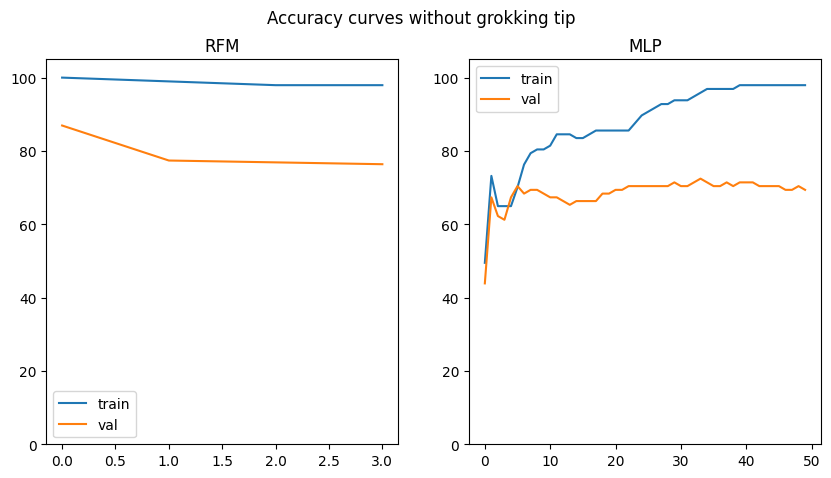

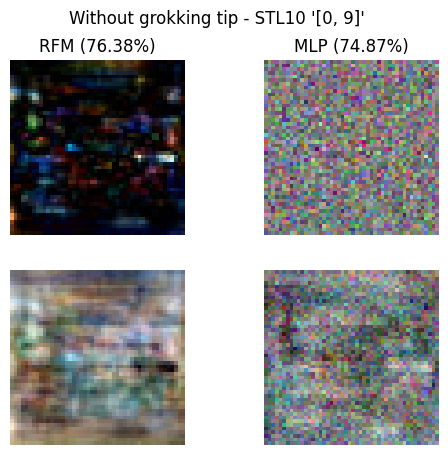

#### With grokking

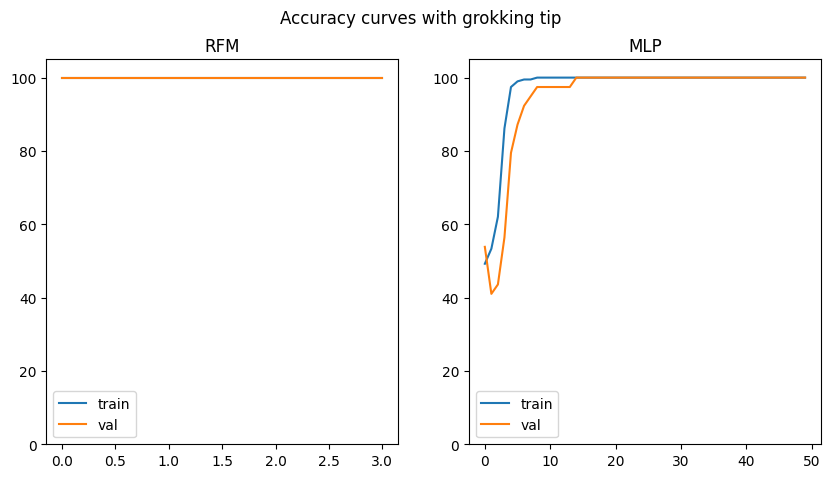

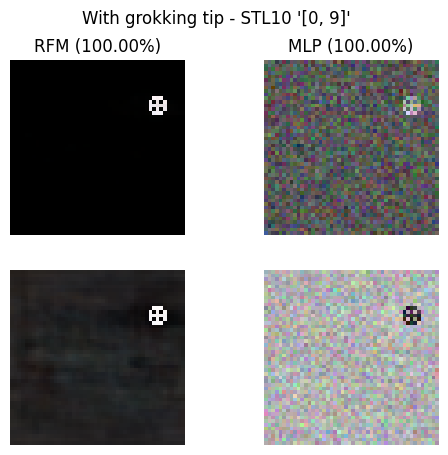

---

In [3]:
from data_utils import get_stl10_balanced_data, split
from preprocess import add_grok_tip

# number of STL10 training samples
GROKKING_STL10_N_TRAIN = 1000
GROKKING_STL10_TARGETS = [0, 9]

display(Markdown(f"### Grokking STL10 __{GROKKING_STL10_TARGETS}__"))

stl10_trainset = get_stl10_balanced_data(
    stl10_trainset_full,
    num_samples=GROKKING_STL10_N_TRAIN,
    targets=GROKKING_STL10_TARGETS,
)

stl10_trainset_wo_grok, stl10_valset_wo_grok = split(stl10_trainset, p=0.5)

display(
    Markdown(
        f"Train size: {len(stl10_trainset_wo_grok)}, eval size: {len(stl10_valset_wo_grok)}"
    )
)

trainloader_wo_grok = torch.utils.data.DataLoader(
    stl10_trainset_wo_grok, batch_size=1024, shuffle=True, num_workers=2
)
valloader_wo_grok = torch.utils.data.DataLoader(
    stl10_valset_wo_grok, batch_size=100, shuffle=False, num_workers=1
)

stl10_testset = get_stl10_balanced_data(
    stl10_testset_full,
    num_samples=GROKKING_STL10_N_TRAIN,
    targets=GROKKING_STL10_TARGETS,
)
testloader_wo_grok = torch.utils.data.DataLoader(
    stl10_testset, batch_size=512, shuffle=False, num_workers=1
)

display(Markdown("#### Without grokking"))

M_rfm, mse_rfm, acc_rfm, accs_rfm = rfm.train(
    trainloader_wo_grok, testloader_wo_grok, iters=4, L=500
)
mlp, mse_mlp, acc_mlp, accs_mlp = nn.train(
    trainloader_wo_grok, valloader_wo_grok, testloader_wo_grok, num_epochs=500, lr=1e-2
)

visualize_curves_dict(
    {"RFM": accs_rfm, "MLP": accs_mlp}, title="Accuracy curves without grokking tip"
)

_, fig = visualize_M_dict(
    {"RFM": (acc_rfm, M_rfm), "MLP": (acc_mlp, mlp.M)},
    title=f"Without grokking tip - STL10 '{GROKKING_STL10_TARGETS}'",
)

plt.show()

# add grokking tip

stl10_trainset_grok = add_grok_tip(stl10_trainset)
stl10_trainset_grok, stl10_valset_grok = split(stl10_trainset_grok, p=0.8)

trainloader_grok = torch.utils.data.DataLoader(
    stl10_trainset, batch_size=1024, shuffle=True, num_workers=2
)
valloader_grok = torch.utils.data.DataLoader(
    stl10_valset_grok, batch_size=100, shuffle=False, num_workers=1
)

stl10_testset_grok = add_grok_tip(stl10_testset)
testloader_grok = torch.utils.data.DataLoader(
    stl10_testset_grok, batch_size=512, shuffle=False, num_workers=1
)

display(Markdown("#### With grokking"))
M_rfm, mse_rfm, acc_rfm, accs_rfm = rfm.train(
    trainloader_grok, testloader_grok, iters=4, L=500
)
mlp, mse_mlp, acc_mlp, accs_mlp = nn.train(
    trainloader_grok, valloader_grok, testloader_grok, num_epochs=500, lr=1e-2
)

visualize_curves_dict(
    {"RFM": accs_rfm, "MLP": accs_mlp}, title="Accuracy curves with grokking tip"
)

visualize_M_dict(
    {"RFM": (acc_rfm, M_rfm), "MLP": (acc_mlp, mlp.M)},
    title=f"With grokking tip - STL10 '{GROKKING_STL10_TARGETS}'",
)
plt.show()

display(Markdown("---"))